In [ ]:
function ConnectButton() {
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);

### Data preparation

In [161]:
path_root = '/content/drive/My Drive/Colab Notebooks/DU/'
path_train = path_root + 'data/Corona_NLP_train.csv'
path_test = path_root + 'data/Corona_NLP_test.csv'
path_models = path_root + 'models/'
path_logs = 'logs/'

In [162]:
!pip install unidecode

In [163]:
import html
import unidecode
from string import ascii_lowercase
import matplotlib.pyplot as plt

def clean_text(df):
    df['x'] = [html.unescape(x) for x in df['x_orig']]
    df['x'] = [re.sub(r'https?://\S+', '', x) for x in df['x']]
    df['x'] = [re.sub(r'[^\w\s]|\d+', '', x) for x in df['x']]
    df['x'] = [re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', x) for x in df['x']]
    df['x'] = [re.sub(r'\s\s+|_|\'', ' ', x) for x in df['x']]
    df['x'] = [x.strip().lower() for x in df['x']]
    df['x'] = [unidecode.unidecode(x) for x in df['x']]

    for c in ascii_lowercase:
        df['x'] = [re.sub(c+'{3,}', c+c, x) for x in df['x']]

In [164]:
import re
import pandas as pd

def load_csv(path):
    df = pd.read_csv(path, encoding='latin')
    df = df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'])
    df = df.rename(columns={'OriginalTweet':'x_orig', 'Sentiment':'y'})

    clean_text(df)

    return df

In [165]:
def show_confusion_matrix(y_true, y_pred):
    plt.matshow(confusion_matrix(y_true, y_pred))
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Classifier 1: Logistic regression

In [166]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [167]:
%%time
train = load_csv(path_train)
vectorizer = TfidfVectorizer()
clf = LogisticRegression(max_iter=500)
model = Pipeline([('vectorizer', vectorizer), ('clf', clf)])
model.fit(train['x'], train['y'])

CPU times: user 38.1 s, sys: 36.2 s, total: 1min 14s
Wall time: 40.9 s


                    precision    recall  f1-score   support

Extremely Negative       0.60      0.41      0.49       592
Extremely Positive       0.67      0.50      0.57       599
          Negative       0.49      0.49      0.49      1041
           Neutral       0.58      0.63      0.61       619
          Positive       0.46      0.60      0.52       947

          accuracy                           0.53      3798
         macro avg       0.56      0.53      0.54      3798
      weighted avg       0.54      0.53      0.53      3798



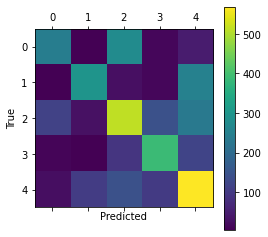

CPU times: user 841 ms, sys: 144 ms, total: 985 ms
Wall time: 1.05 s


In [168]:
%%time
test = load_csv(path_test)
y_pred = model.predict(test['x'])
print(classification_report(test['y'], y_pred))
show_confusion_matrix(test['y'].tolist(), y_pred)

### Classifier 2: DistilBERT

In [ ]:
!pip install transformers
!pip install optuna

In [169]:
import torch
import numpy as np
import tensorflow as tf
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler
from transformers import AutoTokenizer, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

def run_train(train, test, path_model, search_hp):
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

    data_train = tokenizer.batch_encode_plus(
        train['x'].tolist(),
        truncation=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        add_special_tokens=True,
        max_length=50,
        return_tensors='pt')

    data_test = tokenizer.batch_encode_plus(
        test['x'].tolist(),
        truncation=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        add_special_tokens=True,
        max_length=50,
        return_tensors='pt')

    encoder = LabelEncoder()
    train['y_encd'] = encoder.fit_transform(train['y'])
    test['y_encd'] = encoder.fit_transform(test['y'])
    num_labels = train['y_encd'].nunique()

    dataset_train = TensorDataset(
        data_train['input_ids'],
        data_train['attention_mask'],
        torch.tensor(train['y_encd'].tolist()))

    dataset_test = TensorDataset(
        data_test['input_ids'],
        data_test['attention_mask'],
        torch.tensor(test['y_encd'].tolist()))

    callback_stop = EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=1e-6)

    def model_init(trial):
        nonlocal num_labels
        return AutoModelForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=num_labels)

    def data_collator(features):
        return {'input_ids': torch.stack([f[0] for f in features]),
                'attention_mask': torch.stack([f[1] for f in features]),
                'labels': torch.stack([f[2] for f in features])}

    def compute_metrics(eval):
        label_ids = eval.label_ids
        predictions = eval.predictions.argmax(-1)
        return {'accuracy': accuracy_score(label_ids, predictions)}

    args = TrainingArguments(
        output_dir=path_model,
        evaluation_strategy='steps',
        logging_dir=path_logs,
        logging_steps=250,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy')

    trainer = Trainer(
        args=args,
        data_collator=data_collator,
        train_dataset=dataset_train,
        eval_dataset=dataset_test,
        tokenizer=tokenizer,
        model_init=model_init,
        compute_metrics=compute_metrics,
        callbacks=[callback_stop])

    # Optuna hyperparameters
    params = {'learning_rate': 9.654260494767733e-05,
              'num_train_epochs': 3,
              'seed': 22,
              'per_device_train_batch_size': 64}

    if search_hp:
        params = trainer.hyperparameter_search(
            n_trials=20,
            direction='maximize',
            backend='optuna').hyperparameters

    for n, v in params.items():
        print(f'Setting: {n}={v}')
        setattr(trainer.args, n, v)

    trainer.train()
    trainer.save_model(path_model)

def run_test(test, path_model):
    encoder = LabelEncoder()
    test['y_encd'] = encoder.fit_transform(test['y'])
    num_labels = test['y_encd'].nunique()

    dataset_test = TensorDataset(
        data_test['input_ids'],
        data_test['attention_mask'],
        torch.tensor(test['y_encd'].tolist()))

    dataloader_test = DataLoader(
        dataset_test,
        sampler=SequentialSampler(dataset_test),
        batch_size=128)

    model = AutoModelForSequenceClassification.from_pretrained(
        path_model,
        local_files_only=True,
        num_labels=num_labels)

    device = torch.device('cuda')
    model.to(device)

    y_true, y_pred = [], []

    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        y_true.append(inputs['labels'].cpu().numpy())
        y_pred.append(outputs.logits.detach().cpu().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    y_pred = [encoder.classes_[np.argmax(y)] for y in y_pred]
    y_true = [encoder.classes_[y] for y in y_true]

    print(classification_report(y_true, y_pred))

    return y_pred, y_true

In [156]:
!rm -rf '{path_logs}' '{path_models}'
!mkdir -p '{path_logs}' '{path_models}'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '{path_logs}'

#### Classify tweets in 5 classes

In [157]:
train, test = load_csv(path_train), load_csv(path_test)

In [ ]:
%%time
train, test = load_csv(path_train), load_csv(path_test)
run_train(train, test, path_models, True)

In [ ]:
!cp -r '{path_logs}' '{path_models}'

                    precision    recall  f1-score   support

Extremely Negative       0.83      0.80      0.81       592
Extremely Positive       0.88      0.80      0.84       599
          Negative       0.76      0.78      0.77      1041
           Neutral       0.86      0.80      0.83       619
          Positive       0.73      0.80      0.77       947

          accuracy                           0.79      3798
         macro avg       0.81      0.80      0.80      3798
      weighted avg       0.80      0.79      0.80      3798



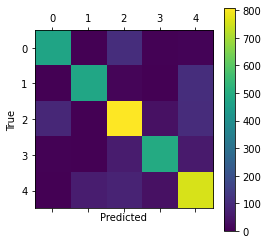

CPU times: user 5.48 s, sys: 2.6 s, total: 8.09 s
Wall time: 12.5 s


In [170]:
%%time
test = load_csv(path_test)
y_pred, y_true = run_test(test, path_models)
show_confusion_matrix(y_true, y_pred)

#### Classify tweets in 3 classes

In [173]:
def load_csv_reduced(path):
    df = load_csv(path)
    df['y'] = df['y'].apply(lambda x: re.sub('Extremely ', '', x))
    return df

In [176]:
path_reduced = f'{path_models}/reduced'
!rm -rf '{path_reduced}'
!mkdir -p '{path_reduced}'

In [177]:
%%time
train, test = load_csv_reduced(path_train), load_csv_reduced(path_test)
run_train(train, test, path_reduced, False)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceCla

Setting: learning_rate=9.654260494767733e-05
Setting: num_train_epochs=3
Setting: seed=22
Setting: per_device_train_batch_size=64


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Step,Training Loss,Validation Loss,Accuracy
250,0.618752,0.471805,0.823855
500,0.412999,0.451950,0.834650
750,0.331967,0.371897,0.875197
1000,0.250467,0.380877,0.872565
1250,0.251544,0.367972,0.872038


CPU times: user 4min 42s, sys: 2min 32s, total: 7min 15s
Wall time: 7min 35s


              precision    recall  f1-score   support

    Negative       0.88      0.89      0.89      1633
     Neutral       0.87      0.78      0.82       619
    Positive       0.87      0.90      0.88      1546

    accuracy                           0.88      3798
   macro avg       0.87      0.86      0.86      3798
weighted avg       0.88      0.88      0.87      3798



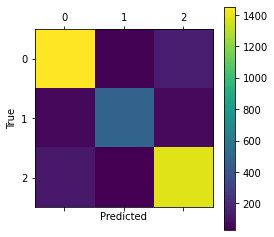

CPU times: user 5.74 s, sys: 2.6 s, total: 8.35 s
Wall time: 8.65 s


In [178]:
%%time
test = load_csv_reduced(path_test)
reduce_classes(train), reduce_classes(test)
y_pred, y_true = run_test(test, path_reduced)
show_confusion_matrix(y_true, y_pred)

### Data exploration

In [179]:
from collections import Counter
from wordcloud import WordCloud

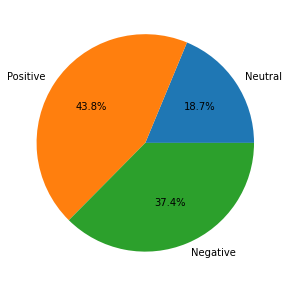

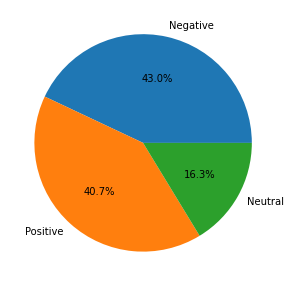

In [180]:
for df in [train, test]:
    y_count = Counter(df['y'])
    plt.figure(figsize=(20, 5))
    plt.pie(y_count.values(), labels=y_count.keys(), autopct='%1.1f%%')
    plt.show()

Neutral


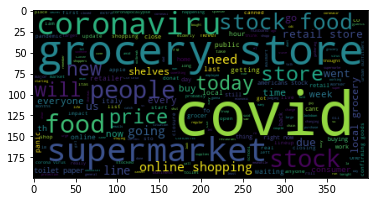

Positive


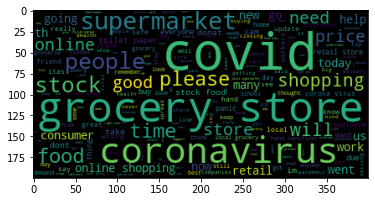

Negative


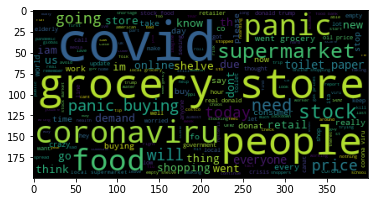

In [181]:
for y in train['y'].unique():
    print(y)
    x = df[df['y'] == y]['x'].to_string()
    plt.imshow(WordCloud().generate(x))
    plt.show()

In [182]:
for y in sorted(train['y'].unique()):
    x = df[df['y'] == y]['x_orig']
    tag_count = len(re.findall('#\w+', x.to_string()))
    tag_ratio = tag_count / x.shape[0]
    print("{:<20}\t{}".format(y, tag_ratio))

Negative            	0.1996325780771586
Neutral             	0.31179321486268174
Positive            	0.21021992238033635
